# TP 5 – Pricing analytique d'options exotiques (asiatiques, spreads, SABR)

Dans ce TP, nous explorons les fonctions du module `pricing.analytical` de fypy.

Objectifs :
- comprendre l'approximation de Vorst pour les options asiatiques arithmetiques;
- voir la formule de Kirk pour les options de spread sur deux sous-jacents;
- introduire le modele SABR et l'approximation de volatilite implicite de Hagan-Obloj.

In [1]:
# Imports pour le TP
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from fypy.pricing.analytical.asian_approx import asian_vorst_approx_price
from fypy.pricing.analytical.spread_option_kirk_method import spread_option_kirk_method
from fypy.pricing.analytical.SabrHaganOblojPricer import SabrHaganOblojPricer
from fypy.model.slv.Sabr import Sabr
from fypy.termstructures.DiscountCurve import DiscountCurve_ConstRate
from fypy.termstructures.EquityForward import EquityForward

%matplotlib inline

/tmp/ipykernel_20110/1133923111.py:4: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.3.4)
  from scipy.stats import norm


## 1. Options asiatiques – approximation de Vorst

Une option asiatique arithmetique sur une action de prix \( S_t \) a un payoff du type :
\[
X = (\bar{S} - K)^+ \quad \text{avec} \quad \bar{S} = \frac{1}{M+1} \sum_{k=0}^{M} S_{t_k}.
\]

Sous Black-Scholes, il n'existe pas de formule fermée simple pour \( \bar{S} \) (moyenne **arithmetique**),
mais la moyenne **geometrique** :
\[
G = \exp\left( \frac{1}{M+1} \sum_{k=0}^{M} \ln S_{t_k} \right)
\]
admet une loi lognormale et donc une formule type Black-Scholes.

L'idee de Vorst (1992) :
- approximer l'option sur moyenne arithmetique par une option sur moyenne geometrique;
- ajuster le strike pour corriger la difference entre espérance de \( \bar{S} \) et \( G \).

La fonction `asian_vorst_approx_price` encapsule ces étapes :
- calcul de \( \mu_G \) et \( \sigma_G \) (paramètres de la loi lognormale approx. de \( G \));
- ajustement de \( K \) en \( K_{adj} \) via les espérances \( E[\bar{S}] \) et \( E[G] \);
- application d'une formule type Black-Scholes sur \( G \) et \( K_{adj} \).

In [2]:
# Exemple : call asiatique arithmetique (approx Vorst)
S0 = 100.0
K = 100.0
sigma = 0.2
r = 0.03
q = 0.0
T = 1.0
M = 12  # observations mensuelles

prix_call_asian = asian_vorst_approx_price(S_0=S0,
                                           sigma=sigma,
                                           M=M,
                                           K=K,
                                           is_call=True,
                                           T=T,
                                           r=r,
                                           q=q,
                                           include_spot_in_average=True)
print('Prix approx. Vorst pour call asiatique (S0=K=100) :', prix_call_asian)

Prix approx. Vorst pour call asiatique (S0=K=100) : 5.176406490043047


**Idée d’exercice** :
- comparer ce prix à une estimation Monte Carlo de \( (\bar{S} - K)^+ \) sous Black-Scholes;
- faire varier `M` pour voir l'effet de la fréquence de monitoring;

## 2. Options de spread à deux actifs – méthode de Kirk

Considérons une option de spread à deux sous-jacents \( S^{(1)}, S^{(2)} \) de payoff :
\[
X = (S_T^{(1)} - S_T^{(2)} - K)^+.
\]

L'idée de la **formule de Kirk** est de ramener ce problème 2D à un problème 1D approché en construisant :
- un sous-jacent "effectif" qui combine \( S^{(1)} \) et \( S^{(2)} + K \);
- une volatilité effective qui dépend de \( \sigma_1, \sigma_2, \rho \) et du ratio \( f_2 / (f_2 + K) \).

La fonction `spread_option_kirk_method` prend directement en compte :
- \( f_1, f_2 \) : forwards des deux actifs;
- \( \sigma_1, \sigma_2, \rho \) : volatilités et corrélation;
- \( K \) : strike du spread.

Elle renvoie un prix approximatif du call sur spread.

In [3]:
# Exemple : option de spread Kirk
S0_1 = 100.0
S0_2 = 90.0
K_spread = 5.0
sigma_1 = 0.25
sigma_2 = 0.2
rho = 0.3
r = 0.02
q1 = 0.0
q2 = 0.0
T = 1.0

prix_spread = spread_option_kirk_method(K=K_spread,
                                       S0_1=S0_1,
                                       S0_2=S0_2,
                                       T=T,
                                       r=r,
                                       rho=rho,
                                       sigma_1=sigma_1,
                                       sigma_2=sigma_2,
                                       q_1=q1,
                                       q_2=q2)
print('Prix approx. Kirk pour option de spread :', prix_spread)

Prix approx. Kirk pour option de spread : 12.279269191983154


## 3. Modèle SABR et approximation de Hagan-Obloj

Le modèle **SABR** (Stochastic Alpha Beta Rho) est souvent utilisé pour décrire les smiles de volatilité sur taux ou
FX. Il postule une dynamique du forward \( F_t \) et de la volatilité \( \alpha_t \) :
\[
\begin{aligned}
dF_t &= \alpha_t F_t^{\beta} \, dW_t^1, \\
d\alpha_t &= \, 
u \alpha_t \, dW_t^2, \\
dW_t^1 dW_t^2 &= \rho \, dt.
\end{aligned}
\]

Hagan et Obloj ont proposé des approximations fermées de la **volatilité implicite Black** \( \sigma_{BS}(K,T) \)
en fonction des paramètres \( (\alpha, \beta, \rho, \nu) \), du strike \( K \) et du forward \( F_0 \).

Dans fypy :
- la classe `Sabr` implémente le modèle et la fonction `implied_vol(K, T, fwd)`;
- `SabrHaganOblojPricer` convertit cette vol implicite en prix Black-76 via `black76_price`.

Nous allons construire une petite courbe forward et tracer un sourire SABR analytique.

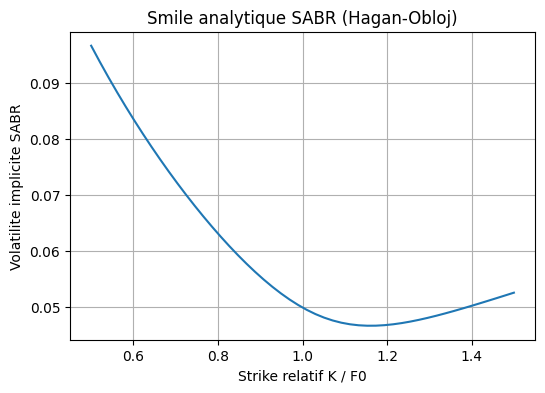

In [4]:
# Paramètres de marché simples
S0 = 100.0
r = 0.01
q = 0.0
T = 1.0

disc_curve = DiscountCurve_ConstRate(rate=r)
div_disc = DiscountCurve_ConstRate(rate=q)
fwd_curve = EquityForward(S0=S0, discount=disc_curve, divDiscount=div_disc)

# Paramètres SABR (exemple typique)
alpha = 0.2   # niveau de vol initiale
beta = 0.5    # contrôle la dépendance à F
rho = -0.3    # corrélation entre prix et vol
nu = 0.5      # vol de la vol

sabr_model = Sabr(alpha=alpha,
                  beta=beta,
                  rho=rho,
                  nu=nu,
                  forwardCurve=fwd_curve,
                  discountCurve=disc_curve)

pricer_sabr = SabrHaganOblojPricer(model=sabr_model)

F0 = fwd_curve(T)
strikes = np.linspace(0.5 * F0, 1.5 * F0, 50)
is_calls = np.ones(len(strikes), dtype=bool)

vols_sabr = np.array([sabr_model.implied_vol(K=K, T=T, fwd=F0) for K in strikes])
prix_sabr = np.array([pricer_sabr.price(T=T, K=K, is_call=True) for K in strikes])

plt.figure(figsize=(6, 4))
plt.plot(strikes / F0, vols_sabr)
plt.xlabel('Strike relatif K / F0')
plt.ylabel('Volatilite implicite SABR')
plt.title('Smile analytique SABR (Hagan-Obloj)')
plt.grid(True)
plt.show()

Vous voyez comment le choix de \( \beta, \rho, \nu \) façonne la forme du smile. En modifiant ces paramètres, vous
pouvez reproduire des smiles plus ou moins marqués et asymétriques.

**Pour aller plus loin :**
- comparer l’approximation Vorst à une simulation Monte Carlo de l’asiatique;
- comparer la formule de Kirk à un pricing Monte Carlo d’un spread 2D corrélé;
- calibrer un modèle SABR à un sourire synthétique en utilisant les outils de calibration de fypy.